In [1]:
! pwd

/Users/haowu/Desktop/Transportation Research/Traffic-Prediction/data_processing/Maryland


In [2]:
%cd ..

/Users/haowu/Desktop/Transportation Research/Traffic-Prediction/data_processing


In [3]:
import pandas as pd
import pickle
import networkx as nx
import numpy as np
import geopandas as gpd
import math

from matplotlib import pyplot as plt
from tqdm import tqdm
from utils import *

In [4]:
# Hyper-parameters 

# Round up to 5 decimal place to avoid mismatch due to mathematical precision
round_decimals = pd.Series(data=5, index=['start_latitude','start_longitude', 'end_latitude', 'end_longitude'])

# Range of neighborhood
range = 5

In [5]:
df_xd_to_tmc = pd.read_csv("./Maryland/hwd_xd_to_tmc.csv")

## 1. Get Upstream and Downstream TMC Segments

1. Select TMC 
2. Calculate immediate prev and next neighbors for each TMC segment using their starting & ending positions
    - If there is multiple prev or next, store as a list
3. Calculate upstream and downstream neighbors for each TMC segment using their immediate prev and next
    - If there is multiple prev or next, the endpoint is a splitting point, we should split into several results 

### 1.1 Select TMC Segments

In [15]:
# TMC Speed Data
'''
Columns:
    'tmc_code', 'measurement_tstamp', 'speed', 'average_speed',
    'reference_speed', 'travel_time_minutes', 'confidence_score', 'cvalue'
'''
df_spd_tmc_all = pickle.load(open("./Maryland/df_downsampled_hwd_spd_tmc_1min_all.pkl", "rb")) # 1093 TMC (106627081,8)
set_spd_tmc_segments = set(df_spd_tmc_all.columns).union(set(df_xd_to_tmc.id_tmc.unique())) # 1093 TMC segments covered in speed data, which is equivalent to geometry data

In [23]:
# TMC Shapefile
gdf_shp_tmc = gpd.read_file("/Volumes/Hao's WD/Howard/Shapefiles/tmc_shape_hwd.geojson")  # id and geometry of 1093 unique tmc segments in cranberry shape file, 1711 of which are covered in "set_spd_tmc_segments"; shape (1093, 16) 
gdf_shp_tmc = gdf_shp_tmc.rename(columns={"tmc":"id_tmc"})
gdf_shp_tmc = gdf_shp_tmc.round(decimals=round_decimals)  # round up to 5 decimal place to avoid mismatch due to mathematical precision, e.g. I missed "104-06225" and "104-06224" previously due to unaligned mathematical precisions.

set_shp_tmc_segments = set(gdf_shp_tmc.id_tmc) # 1093 TMC segments covered in shapefile

In [50]:
# 1093 TMC segments covered in speed data and shapefile
set_tmc_segments_in_spd_shp = set_spd_tmc_segments.intersection(set_shp_tmc_segments)  # 1093 TMC segments, equivalent to set_tmc_segments_within_shp
pickle.dump(set_tmc_segments_in_spd_shp, open("./Maryland/set_hwd_tmc_segments_in_spd_shp.pkl", "wb"))

<AxesSubplot: title={'center': 'Visualization of 1093 Cranberry TMC Segments, all of which has Speed Data'}>

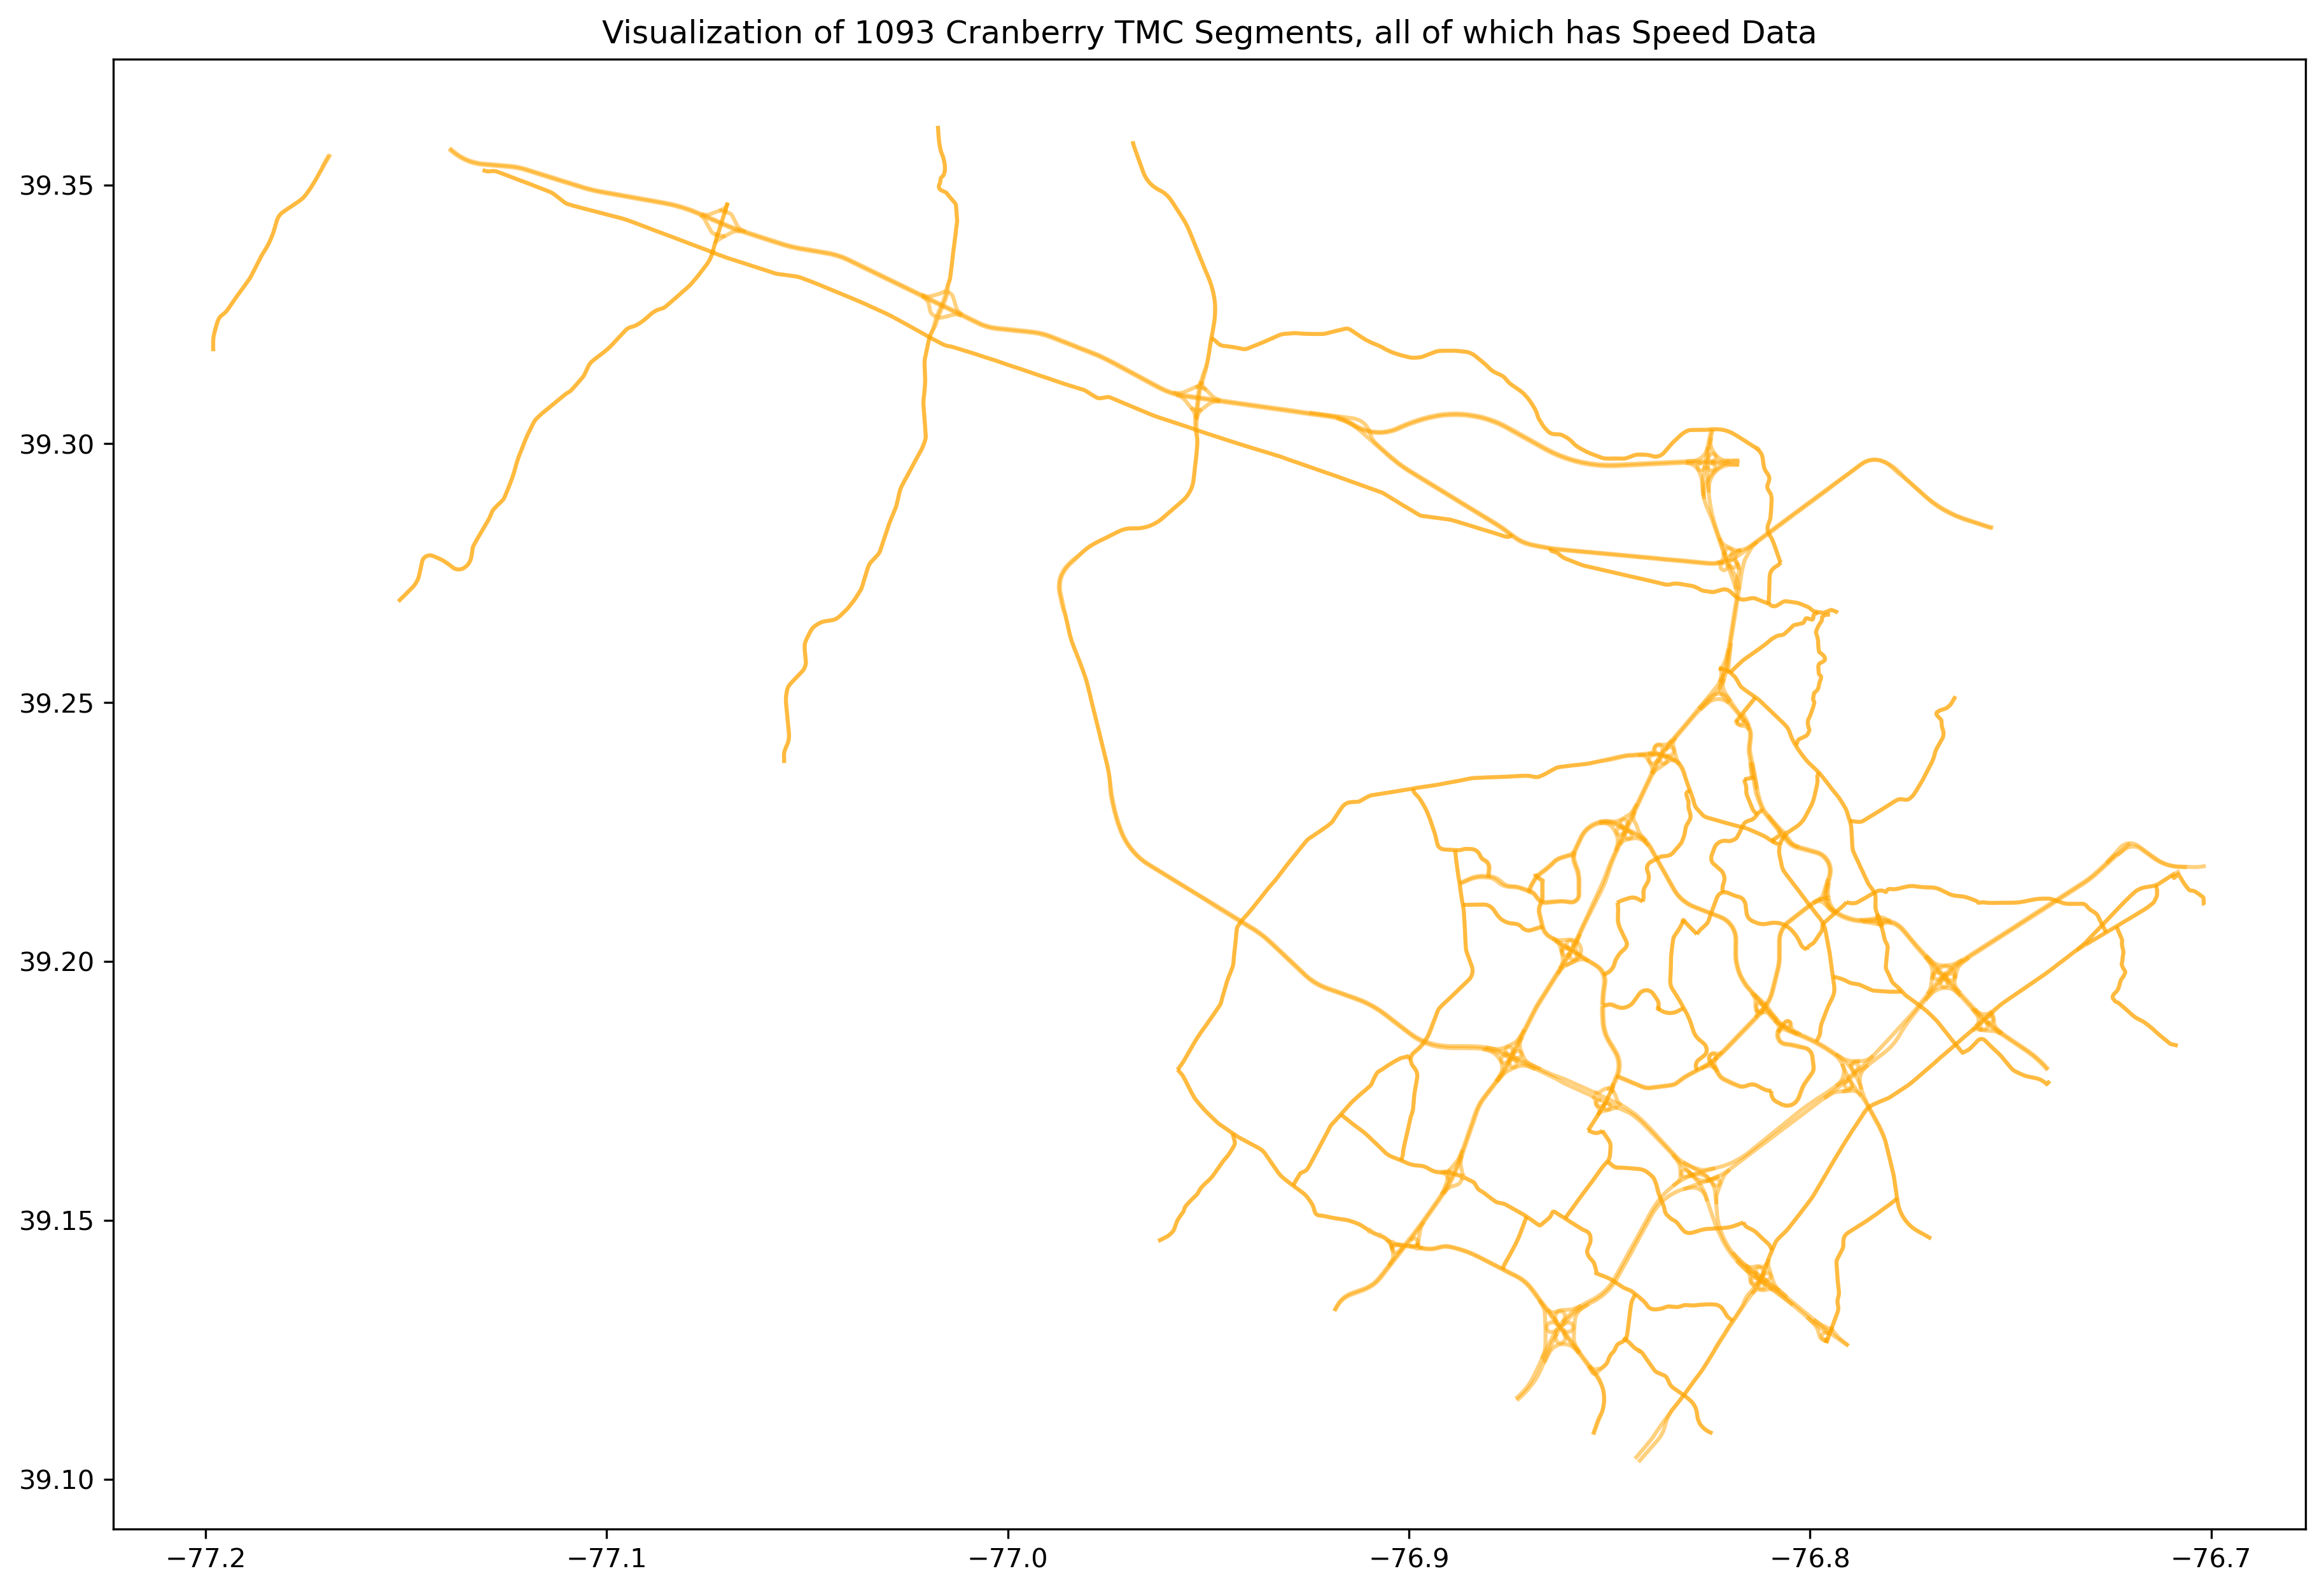

In [26]:
# Visualize TMC segments covered in different sources
fig, ax = plt.subplots(1,figsize=(30,10), dpi=300)
ax.set_title("Visualization of 1093 Cranberry TMC Segments, all of which has Speed Data")
gdf_shp_tmc.plot(ax=ax, color="orange", alpha=0.5)

In [49]:
dict_miles_tmc = dict(gdf_shp_tmc[["id_tmc", "miles"]].values)
with open("./Maryland/dict_hwd_miles_tmc_for_upstream.pkl", "wb") as f:
    pickle.dump(dict_miles_tmc, f)

### 1.2 Calculate immediate prev and next neighbors for each TMC segment using their starting & ending positions

#### 1.2.1 Previous Segment

In [30]:
# Step 1. Join starting and ending positions
df_raw_prev_tmc_1093 = pd.merge(left=gdf_shp_tmc, right=gdf_shp_tmc, left_on=["start_latitude", "start_longitude"], right_on=["end_latitude", "end_longitude"], how="left") # shape (1740, 32)

# All 1093 TMC segments should be covered in both shape and speed data
# Also, the prev neighbor segments of those 273 starting TMC segments should be covered in shapefile and speed data
df_raw_prev_tmc = df_raw_prev_tmc_1093[df_raw_prev_tmc_1093.id_tmc_y.isin(set_tmc_segments_in_spd_shp)] # includes 1016 starting TMC segments matched with 1016 prev neighbors, shape (1740, 32)

In [33]:
len(set(df_raw_prev_tmc.id_tmc_y))

1016

In [34]:
# It's noted that entries in "direction" column is not "clean"
# We will take care of them in manual checking of direction/angle.
df_raw_prev_tmc.direction_x.unique()  

array(['SOUTHBOUND', 'WESTBOUND', 'MD-32 EASTBOUND', 'MD-32 WESTBOUND',
       'SNOWDEN RIVER PKWY', 'MD-175/PATUXENT PKWY EASTBOUND',
       'SNOWDEN RIVER PKWY NORTHBOUND',
       'SNOWDEN RIVER PKWY AND COLUMBIA GATEWAY DR SOUTHBOUND',
       'SNOWDEN RIVER PKWY SOUTHBOUND', 'ROBERT FULTON DR WESTBOUND',
       'I-70 WESTBOUND', 'MD-100 EASTBOUND', 'I-70 EASTBOUND',
       'I-95 SOUTHBOUND', 'US-29/COLUMBIA PIKE SOUTHBOUND',
       'I-70/US-40/BALTIMORE NATIONAL PIKE WESTBOUND',
       'US-29/COLUMBIA PIKE NORTHBOUND', 'I-95 NORTHBOUND', 'NORTHBOUND',
       'I-70/US-40/BALTIMORE NATIONAL PIKE EASTBOUND',
       'US-1/WASHINGTON BLVD NORTHBOUND AND MD-32 EASTBOUND',
       'MD-32/SYKESVILLE RD NORTHBOUND', 'US-1/WASHINGTON BLVD',
       'US-1/WASHINGTON BLVD NORTHBOUND', 'EASTBOUND',
       'DORSEY RUN RD NORTHBOUND', 'DORSEY RUN RD SOUTHBOUND',
       'LONG GATE PKWY NORTHBOUND', 'LONG GATE PKWY', 'MD-100 WESTBOUND',
       'MD-108/OLD ANNAPOLIS RD', 'MD-104/WATERLOO RD NORTHBOUND'

In [35]:
# Step 2. Compute angle  
df_raw_prev_tmc["angle"] = df_raw_prev_tmc.apply(lambda x: angle_neighbor(x.geometry_x, x.geometry_y), axis=1)

/var/folders/y2/1kk0np3x01qchz21plxx_m0w0000gn/T/ipykernel_22157/600702446.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw_prev_tmc["angle"] = df_raw_prev_tmc.apply(lambda x: angle_neighbor(x.geometry_x, x.geometry_y), axis=1)


In [36]:
# summary of angle
df_raw_prev_tmc.angle.describe()

count    1740.000000
mean        0.347748
std         0.412337
min         0.000000
25%         0.011911
50%         0.065092
75%         0.820706
max         1.000000
Name: angle, dtype: float64

In [37]:
df_raw_prev_tmc_checked_angle = df_raw_prev_tmc[df_raw_prev_tmc.angle < 0.75] # 980 starting TMC segments, (1300, 33)

In [38]:
# summary of angle
df_raw_prev_tmc_checked_angle.angle.describe()

count    1300.000000
mean        0.129189
std         0.195639
min         0.000000
25%         0.007949
50%         0.027108
75%         0.121119
max         0.742651
Name: angle, dtype: float64

<AxesSubplot: title={'center': 'Visualization of 1093 Cranberry TMC Segments, all of which has Speed Data'}>

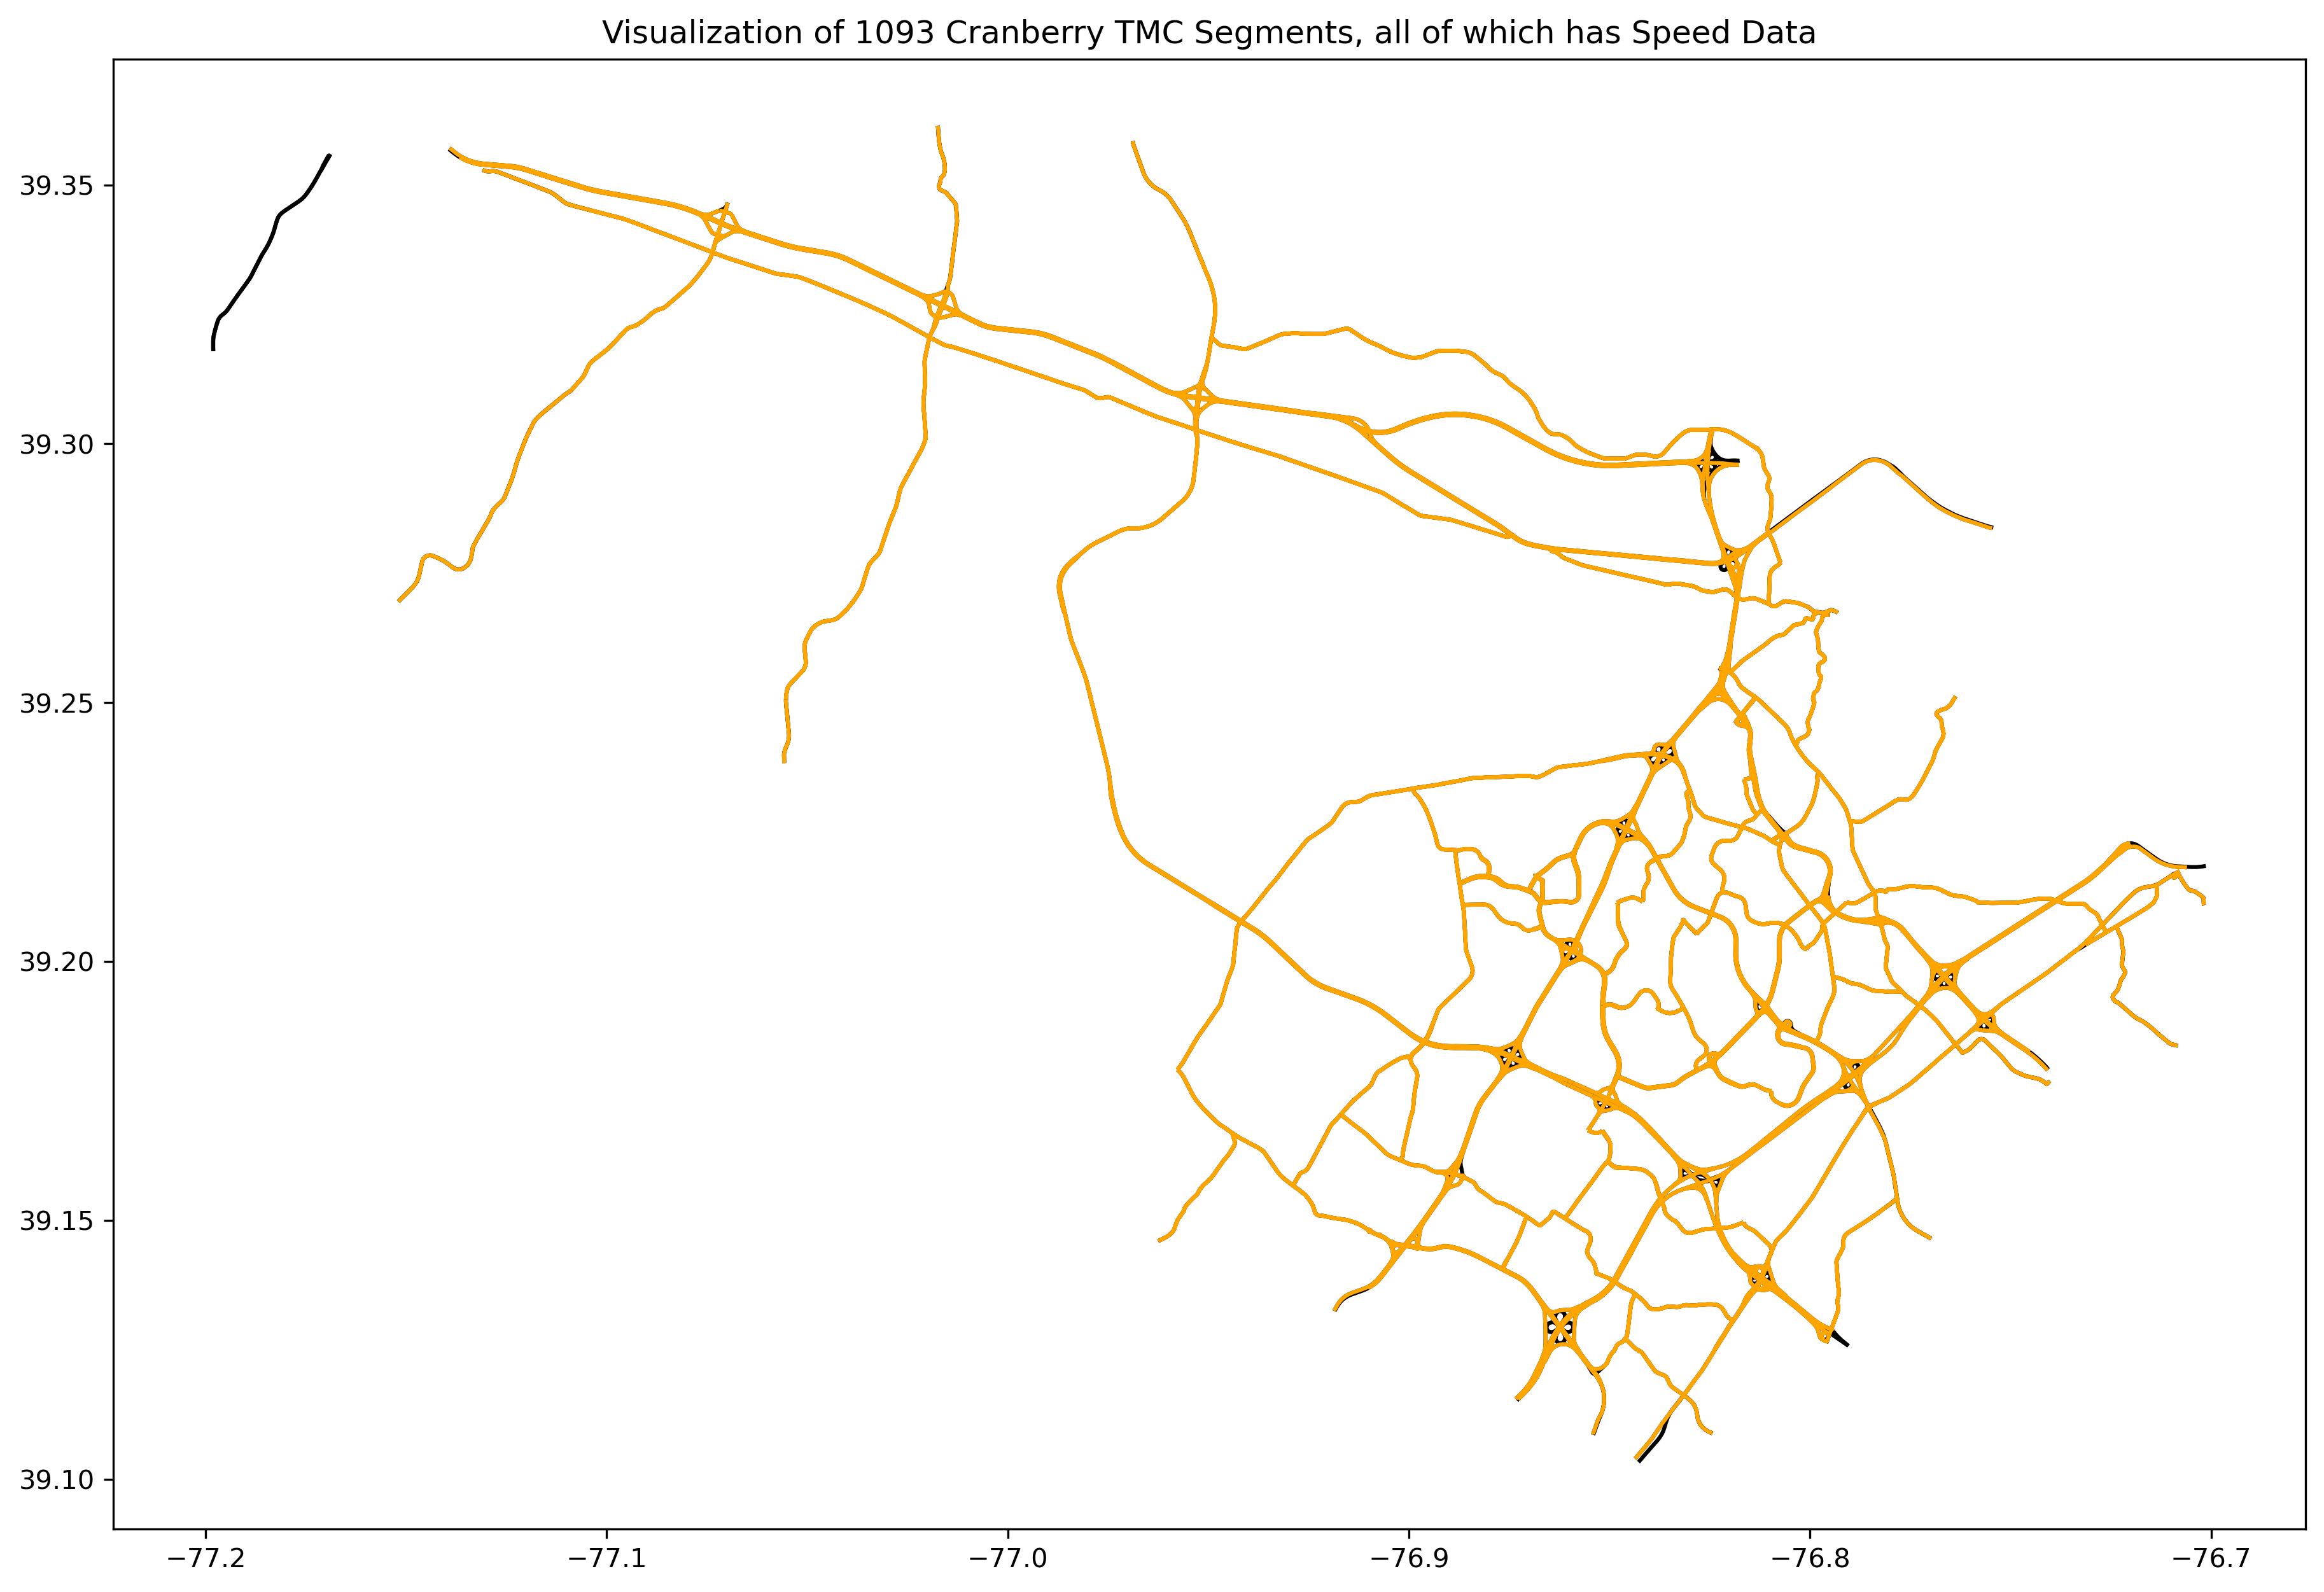

In [45]:
# Visualize TMC segments covered in different sources
fig, ax = plt.subplots(1,figsize=(30,10), dpi=300)
ax.set_title("Visualization of 1093 Cranberry TMC Segments, all of which has Speed Data")
gdf_shp_tmc.plot(ax=ax, color="black")
gdf_shp_tmc[gdf_shp_tmc.id_tmc.isin(df_raw_prev_tmc_checked_angle.id_tmc_x)].plot(ax=ax, color="orange")

In [48]:
# Step 3. output raw csv file for manual checking
df_raw_prev_tmc_checked_angle.to_csv("./Maryland/hwd_raw_prev_tmc.csv", index=False)  # 1300 pairs, 348 of which have angle > 0.1

# I have decided not to auto-check direction, but manually chceck directions, as there are cases where neighbors can have opposite directions.
# df_raw_prev_tmc["direction_matchness"] = df_raw_prev_tmc.apply(lambda x: check_direction(x.direction_x, x.direction_y), axis=1)
# df_raw_prev_tmc = df_raw_prev_tmc[df_raw_prev_tmc.direction_matchness == 1].reset_index(drop=True) # includes 884 TMC segments, shape (1131, 34) 